# VIC: Introduction to Visual Computing - 2020
## Assignment 1
## Author: Clément Bonnet
This assignment has three problems that you need to address. 

Let us load the required libraries first. 

In [1]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import convolve
import warnings
warnings.filterwarnings('ignore')
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm

## 1. The Bilateral Filter

For the first problem, we will have to implement the bilateral filter for smoothing off the images.
* You can use the valve image that you can find in your folder to validate the filter.
* Test the filtering and plot the results for neighhoods of 3x3 and 5x5
* Evaluate the performance with the Gaussian smoothing visually and write a small comment with some conclusions

In [2]:
def bilateral_filtering(img, sigma_s=1, sigma_r=1, neigh=None):
    """
    The Bilateral Filtering.
    
    Inputs:
        img              The input image
        sigma_s          Spatial standard deviation
        sigma_r          Gaussian value standard deviation
        neigh            The neighborhoud of pixels
                         
    Outputs: 
        bilateral_img    A smoothed image
    """
    if neigh is None:
        # Cover 99.7% of the spatial space around the pixel
        neigh = int(3*sigma_s+1)
        
    def gaussian(r2, sigma):
        return np.exp(0.5*r2/sigma**2)
    
    bilateral_img = np.zeros_like(img, dtype=np.float)
    sum_ = np.zeros_like(img, dtype=np.float)
    height, width = img.shape
    
    for y_shift in range(-neigh, neigh+1):
        for x_shift in range(-neigh, neigh+1):
            # Compute the spatial Gaussian weight
            w_g = gaussian(x_shift**2+y_shift**2, sigma_s)

            # Shift the image by the offsets
            offset = np.roll(img, [y_shift, x_shift], axis=[0,1] )

            # Compute the shifted weights to be added to the image
            w_s = w_g*gaussian(np.power(offset-img, 2), sigma_r)

            # accumulate the results
            bilateral_img += offset*w_s
            sum_ += w_s
            
    return (bilateral_img/sum_).astype(np.int)

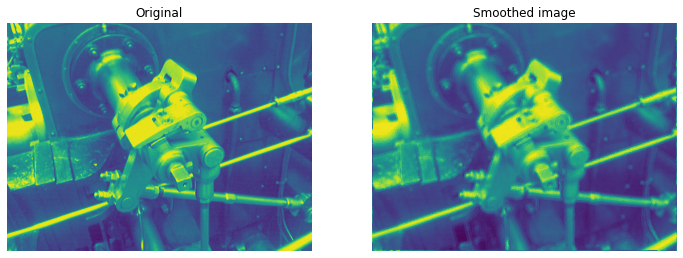

In [3]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bilateral = bilateral_filtering(img, sigma_s=5, sigma_r=5, neigh=2)
bilateral2 = bilateral_filtering(img, sigma_s=0.3, sigma_r=3)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(bilateral)
plt.axis('off')
plt.title('Smoothed image')

plt.show()

## 2. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 2.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 2.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 2.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 2.D Double thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than `hi` will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

#### 2.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [4]:
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2, sigma_g=3):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    def gaussian_smoothing(img, sigma):
        smoothed = gaussian_filter(img, sigma)
        return smoothed
    smoothed             = gaussian_smoothing(img, sigma=sigma_g)
    
    
    # Find gradient magnitude and direction
    def gradient(img):
        kernel_x = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]], np.float)
        kernel_y = np.array([[1, 2, 1],
                             [0, 0, 0],
                             [-1, -2, -1]], np.float)
        grad_x = convolve(img, kernel_x)
        grad_y = convolve(img, kernel_y)
        g_magnitude = np.sqrt(np.square(grad_x) + np.square(grad_y))
        g_dir = np.arctan2(grad_y, grad_x)
        return g_magnitude, g_dir
    g_magnitude, g_dir   = gradient(smoothed)
    
    
    # Non-maximum suppression
    def non_maximum_suppression(g_magnitude, g_dir):
        g_max = g_magnitude.copy()
        g_dir = (g_dir/(np.pi/2)*4).astype(np.int).clip(0,3)   # from 0 to 3, times pi/4
        height, width = g_magnitude.shape
        for y in range(height):
            for x in range(width):
                if g_dir[y,x] == 0:
                    if g_magnitude[y,x] < g_magnitude[min(y+1,height-1),x] or g_magnitude[y,x] < g_magnitude[max(y-1,0),x]:
                        g_max[y,x] = 0
                elif g_dir[y,x] == 1:
                    if g_magnitude[y,x] < g_magnitude[min(y+1,height-1),min(x+1,width-1)] or g_magnitude[y,x] < g_magnitude[max(y-1,0),max(x-1,0)]:
                        g_max[y,x] = 0
                elif g_dir[y,x] == 2:
                    if g_magnitude[y,x] < g_magnitude[y,min(x+1,width-1)] or g_magnitude[y,x] < g_magnitude[y,max(x-1,0)]:
                        g_max[y,x] = 0
                elif g_dir[y,x] == 3:
                    if g_magnitude[y,x] < g_magnitude[max(y-1,0),min(x+1,width-1)] or g_magnitude[y,x] < g_magnitude[min(y+1,height-1),max(x-1,0)]:
                        g_max[y,x] = 0
        return g_max
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    def double_thresholding(grad, thresh_lo, thresh_hi):
        thresh_img = grad.copy()
        thresh_lo = thresh_lo*grad.max()
        thresh_hi = thresh_hi*grad.max()
        thresh_img[grad < thresh_hi] = thresh_lo
        thresh_img[grad < thresh_lo] = 0
        thresh_img[grad >= thresh_hi] = thresh_hi
        return (thresh_img*255/thresh_hi).astype(np.int)
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)

    return thresh_img

Now test the code on a sample image&mdash;

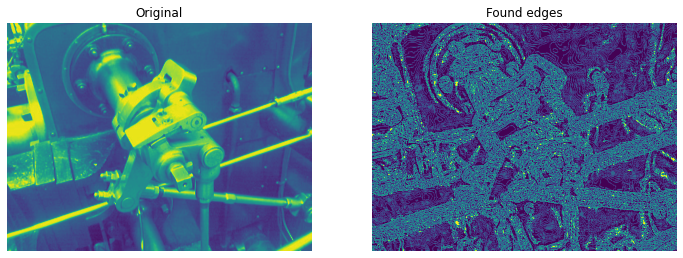

In [5]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = canny_edge_detector(img, thresh_lo=0.2, thresh_hi=0.6, sigma_g=5)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges)
plt.axis('off')
plt.title('Found edges')

plt.show()

## 3. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

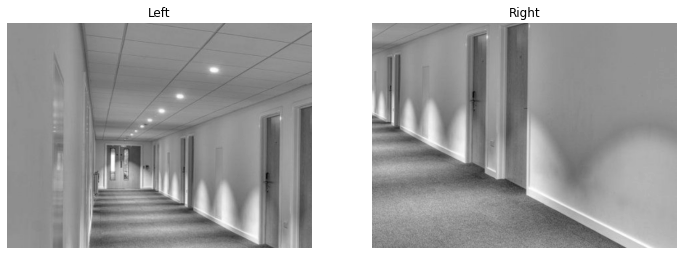

In [6]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images implementing by your own the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [7]:
def harris_corner_detector(img, thresh):
    dst = cv2.cornerHarris(img,2,3,0.04)
    corners = []
    max_ = dst.max()
    for y in range(dst.shape[0]):
        for x in range(dst.shape[1]): 
            if dst[y,x] > thresh*max_:
                corners.append([x,y])
    return corners

def find_random_pair(corners_left, corners_right):
    i_left = np.random.randint(len(corners_left))
    i_right = np.random.randint(len(corners_right))
    c_left = corners_left[i_left]
    c_right = corners_right[i_right]
    if c_left[0] > c_right[0] or c_left[1] > c_right[1]:
        c_left, c_right = find_random_pair(corners_left, corners_right)
    return c_left, c_right
    
def find_translation_vector(c_left, c_right):
    x_right, y_right = c_right
    x_left, y_left = c_left
    return (x_right - x_left, y_right - y_left)

def compute_error(x_trans, y_trans, left, right):
    err = 0
    for y in range(left.shape[0]-y_trans):
        for x in range(left.shape[1]-x_trans):
            err += abs(left[y+y_trans,x+x_trans] - right[y,x])
    return err/(1e-10 + (left.shape[1]-x_trans-1)*(left.shape[0]-y_trans-1))

def stitch_images(left, right, max_tries=1000, harris_thresh=0.1):
    # Find corner points
    corners_left  = harris_corner_detector(left, thresh=harris_thresh)
    corners_right = harris_corner_detector(right, thresh=harris_thresh)
    
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in tqdm(range(max_tries)):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)
        
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Compute resulting error. 
        this_error       = compute_error(x_trans, y_trans, left, right)
        if this_error < best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
    
    x_trans, y_trans = best_trans
    stiched_image_shape = (left.shape[0] + y_trans, left.shape[1] + x_trans)
    stitched_image = np.zeros(stiched_image_shape)
    for y in range(stiched_image_shape[0]):
        for x in range(stiched_image_shape[1]):
            if x < x_trans or y < y_trans:
                if x < left.shape[1] and y < left.shape[0]:
                    stitched_image[y,x] = left[y,x]
                else:
                    stitched_image[y,x] = 0
            else:
                if x < left.shape[1] and y < left.shape[0]:
                    stitched_image[y,x] = int(0.5 * left[y,x] + 0.5 * right[y-y_trans, x-x_trans])
                else:
                    stitched_image[y,x] = right[y-y_trans, x-x_trans]
            
    return stitched_image

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:19<00:00,  5.01it/s]


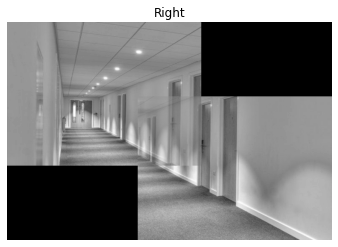

In [8]:
stitched_image = stitch_images(left_img, right_img, max_tries=1000, harris_thresh=0.05)
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 

Here we used a single vector to translate the right image. In a more complicated scenario, we could use any function to go from one picture to another, including rotation, scaling, etc...